# Methodological Foundation of a Numerical Taxonomy of Urban Form

This notebook serves as a template for morphometric assessment and generation of a taxonomy.

## Reproducible Python code to generate taxonomy

Complete morphometrics assessment from input data to taxonomy.

Input data:
 - building footprints
 - street network
 
This notebook is running the analysis on the sample of the data used in Prague case study. You can replace the sample with your own data, assuming that they are cleaned to a required standard. 

The sample is saved in `../files/sample.gpkg` with two layers named `buildings` and `streets`. `buildings` are Polygons, whilst `streets` are LineStrings.

Buildings data contain a single attribute column:

- `height` - building height in meters.

This notebook has been updated to work with `momepy` 0.5 and `geopandas` 0.10. The original work has been carried out using `momepy` 0.3 within the Docker container `darribas/gds_py:5.0`.

First we import all required libraries.

In [2]:
import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from tqdm import tqdm
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy

### Check the input data

We load buildings and create unique ID.

In [3]:
path = "../files/sample.gpkg"
layer = "buildings"
buildings = gpd.read_file(path, layer=layer)

In [4]:
buildings

,height,geometry
0,21.0,"POLYGON ((-742025.710 -1046985.128, -742034.55..."
1,21.0,"POLYGON ((-742104.965 -1046933.503, -742097.25..."
2,3.5,"POLYGON ((-741593.210 -1046979.950, -741618.97..."
3,14.0,"POLYGON ((-741919.403 -1046959.955, -741901.95..."
4,17.5,"POLYGON ((-741925.795 -1046956.295, -741908.29..."
...,...,...
12879,21.0,"POLYGON ((-741769.470 -1041962.200, -741770.57..."
12880,14.0,"POLYGON ((-741832.430 -1041971.060, -741823.83..."
12881,21.0,"POLYGON ((-741859.560 -1041966.040, -741859.54..."
12882,21.0,"POLYGON ((-741926.911 -1041977.900, -741914.06..."


<AxesSubplot:>

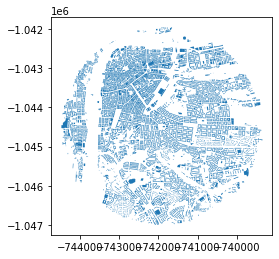

In [5]:
buildings.plot()

Let's create a persistent unique identifier for each building.

In [6]:
buildings["uID"] = range(len(buildings))

### Generate additional morphometric elements

Before we can start morhometrics we have to generate additional elements - tessellation and tessellation based blocks.

#### Morphological tessellation

Check input for tessellation. If the input data is clean, the check will result in zeros. The data does not have to be 100% clean (all 0). For example `Split features` may not cause any issue. 

In [7]:
check = mm.CheckTessellationInput(buildings)

Collapsed features  : 0
Split features      : 48
Overlapping features: 0


Generate tessellation limited to 100 m buffer. Beware, it is memory demanding.

**Note:** You may find that this step requires more memory that you are able to provide. In that case, you may consider using an [enclosed tessellation](http://docs.momepy.org/en/stable/user_guide/elements/enclosed.html) method instead. However, that would require minor adaptation of the code below as well.

In [8]:
limit = mm.buffered_limit(buildings, 100)

tessellation = mm.Tessellation(buildings, "uID", limit)
tessellation = tessellation.tessellation

Inward offset...


/opt/miniconda3/envs/stable/lib/python3.9/site-packages/momepy/elements.py:280: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  objects = objects.reset_index(drop=True).explode()


Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


/opt/miniconda3/envs/stable/lib/python3.9/site-packages/momepy/elements.py:391: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [8468, 9450, 12837, 2142, 8575]
  warnings.warn(


In [9]:
tessellation

,uID,geometry
1,1,"POLYGON ((-742152.139 -1047034.980, -742150.61..."
6,6,"POLYGON ((-742345.550 -1046997.611, -742345.31..."
17,17,"POLYGON ((-742406.381 -1046976.489, -742429.31..."
43,43,"POLYGON ((-742433.833 -1046906.106, -742434.05..."
100,100,"POLYGON ((-742445.365 -1046853.350, -742444.81..."
...,...,...
12784,12784,"POLYGON ((-740625.011 -1042548.009, -740624.75..."
12768,12768,"POLYGON ((-740593.839 -1042553.038, -740594.22..."
12799,12799,"POLYGON ((-740579.284 -1042534.329, -740579.32..."
12832,12832,"POLYGON ((-740648.529 -1042427.975, -740648.57..."


<AxesSubplot:>

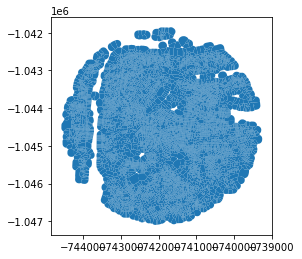

In [10]:
tessellation.plot()

We save tessellation to file. Note that this file is not part of the repository but can be fully created using the input sample and this notebook.

In [11]:
tessellation.to_file("../files/geometry.gpkg", layer="tessellation")

### Tessellation based blocks

To generate tessellation based blocks we also need street network, therefore we need to read it to GeoDataFrame first.

In [12]:
streets = gpd.read_file(path, layer='streets')

In [13]:
streets

,geometry
0,"LINESTRING (-742433.016 -1046264.808, -742436...."
1,"LINESTRING (-742488.604 -1046309.299, -742433...."
2,"LINESTRING (-742433.016 -1046264.808, -742403...."
3,"LINESTRING (-742591.967 -1046076.716, -742536...."
4,"LINESTRING (-742603.997 -1046092.676, -742591...."
...,...
2638,"LINESTRING (-743897.637 -1043082.976, -743862...."
2639,"LINESTRING (-739619.383 -1045339.927, -739547...."
2640,"LINESTRING (-741973.637 -1045689.976, -741938...."
2641,"LINESTRING (-743820.284 -1042903.602, -743822...."


To create blocks within the full `limit`, it is always safer to extend street network to the edge of the limit.

In [14]:
extended = mm.extend_lines(streets, tolerance=120, target=gpd.GeoSeries([limit.boundary]), barrier=buildings)

/opt/miniconda3/envs/stable/lib/python3.9/site-packages/momepy/preprocessing.py:480: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = gdf.reset_index(drop=True).explode().reset_index(drop=True)


In [15]:
blocks = mm.Blocks(tessellation, edges=extended, buildings=buildings, id_name='bID', unique_id='uID')
blocks_df = blocks.blocks  # get blocks df
buildings['bID'] = blocks.buildings_id  # get block ID
tessellation['bID'] = blocks.tessellation_id  # get block ID

/opt/miniconda3/envs/stable/lib/python3.9/site-packages/momepy/elements.py:628: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  cut = gpd.overlay(
/opt/miniconda3/envs/stable/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/stable/lib/python3.9/site-packages/momepy/elements.py:647: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  blocks = cells_copy.dissolve(by="component").explode().reset_index(drop=True)
/opt/miniconda3

#### Link streets

We need to understand which building belongs to which street segment. We link IDs together based on proximity.

In [16]:
streets["nID"] = range(len(streets))
buildings['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300)
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

Snapping: 100%|██████████| 12884/12884 [00:32<00:00, 392.38it/s]


Finally, we save elements to a file.

In [17]:
path = '../files/geometry.gpkg'
tessellation.to_file(path, layer='tessellation', driver='GPKG')
buildings.to_file(path, layer='buildings', driver='GPKG')
blocks_df.to_file(path, layer='blocks', driver='GPKG')

## Measure primary characters

This part measures 74 primary morphometric characters.

It does save intermediate parquet files as a backup.

In [18]:
blocks = blocks_df

Note: 

- `height` is building height in meters. If you do not have it, skip affected lines.

In [19]:
buildings['floor_area'] = (buildings["height"] / 3.5) * buildings.area

In [21]:
buildings['sdbAre'] = mm.Area(buildings).series
buildings['sdbVol'] = mm.Volume(buildings, 'height', 'sdbAre').series
buildings['sdbPer'] = mm.Perimeter(buildings).series
buildings['sdbCoA'] = mm.CourtyardArea(buildings, 'sdbAre').series

buildings['ssbFoF'] = mm.FormFactor(buildings, 'sdbVol', 'sdbAre').series
buildings['ssbVFR'] = mm.VolumeFacadeRatio(buildings, 'height', 'sdbVol', 'sdbPer').series
buildings['ssbCCo'] = mm.CircularCompactness(buildings, 'sdbAre').series
buildings['ssbCor'] = mm.Corners(buildings).series
buildings['ssbSqu'] = mm.Squareness(buildings).series
buildings['ssbERI'] = mm.EquivalentRectangularIndex(buildings, 'sdbAre', 'sdbPer').series
buildings['ssbElo'] = mm.Elongation(buildings).series

  0%|          | 0/12884 [00:00<?, ?it/s]/opt/miniconda3/envs/stable/lib/python3.9/site-packages/momepy/shape.py:795: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  1%|          | 152/12884 [00:00<00:08, 1498.39it/s]/opt/miniconda3/envs/stable/lib/python3.9/site-packages/momepy/shape.py:919: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
100%|██████████| 12884/12884 [00:07<00:00, 1689.85it/s]


In [22]:
cencon = mm.CentroidCorners(buildings)
buildings['ssbCCM'] = cencon.mean
buildings['ssbCCD'] = cencon.std

  2%|▏         | 201/12884 [00:00<00:06, 2006.62it/s]/opt/miniconda3/envs/stable/lib/python3.9/site-packages/momepy/shape.py:1147: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
100%|██████████| 12884/12884 [00:08<00:00, 1569.58it/s]


In [23]:
buildings['stbOri'] = mm.Orientation(buildings).series
 
tessellation['stcOri'] = mm.Orientation(tessellation).series
buildings['stbCeA'] = mm.CellAlignment(buildings, tessellation, 'stbOri', 'stcOri', 'uID', 'uID').series

100%|██████████| 12884/12884 [00:43<00:00, 294.31it/s]


In [24]:
tessellation['sdcLAL'] = mm.LongestAxisLength(tessellation).series
tessellation['sdcAre'] = mm.Area(tessellation).series
tessellation['sscCCo'] = mm.CircularCompactness(tessellation, 'sdcAre').series
tessellation['sscERI'] = mm.EquivalentRectangularIndex(tessellation, 'sdcAre').series

In [27]:
buildings["mtbSWR"] = mm.SharedWallsRatio(buildings, "sdbPer").series
 
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID")
 
buildings["mtbAli"] = mm.Alignment(buildings, queen_1, "uID", "stbOri").series
buildings["mtbNDi"] = mm.NeighborDistance(buildings, queen_1, "uID").series
tessellation["mtcWNe"] = mm.Neighbors(tessellation, queen_1, "uID", weighted=True).series
tessellation["mdcAre"] = mm.CoveredArea(tessellation, queen_1, "uID").series

In [ ]:
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
 
buildings["libNCo"] = mm.Courtyards(buildings, spatial_weights=buildings_q1).series
buildings["ldbPWL"] = mm.PerimeterWall(buildings, buildings_q1).series
 
blocks["ldkAre"] = mm.Area(blocks).series
blocks["ldkPer"] = mm.Perimeter(blocks).series
blocks["lskCCo"] = mm.CircularCompactness(blocks, "ldkAre").series
blocks["lskERI"] = mm.EquivalentRectangularIndex(blocks, "ldkAre", "ldkPer").series
blocks["lskCWA"] = mm.CompactnessWeightedAxis(blocks, "ldkAre", "ldkPer").series
blocks["ltkOri"] = mm.Orientation(blocks).series
 
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blocks, ids="bID")
 
blocks["ltkWNB"] = mm.Neighbors(blocks, blo_q1, "bID", weighted=True).series
blocks["likWBB"] = mm.Count(blocks, buildings, "bID", "bID", weighted=True).series

Save data to parquets as a checkpoint backup.

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
blocks.drop(columns='geometry').to_parquet('../files/blocks_data.parquet')

In [ ]:
queen_3 = mm.sw_high(k=3, weights=queen_1)

buildings['ltbIBD'] = mm.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3).series
buildings['ltcBuA'] = mm.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1).series

In [26]:
tessellation = tessellation.merge(buildings[['floor_area', 'uID']], on='uID', how='left')
tessellation['licGDe'] = mm.Density(tessellation, 'floor_area', queen_3, 'uID', 'sdcAre').series
tessellation = tessellation.drop(columns='floor_area')
tessellation['ltcWRB'] = mm.BlocksCount(tessellation, 'bID', queen_3, 'uID').series
tessellation['sicCAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'sdbAre', 'uID').series
tessellation['sicFAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'floor_area', 'uID').series

AttributeError: 'Tessellation' object has no attribute 'merge'

Save data to parquets and spatial weights matrices to gal files.

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
 
fo = libpysal.io.open('../files/queen_1.gal', 'w')
fo.write(queen_1)
fo.close()
 
fo = libpysal.io.open('../files/queen_3.gal', 'w')
fo.write(queen_3)
fo.close()
 
fo = libpysal.io.open('../files/buildings_q1.gal', 'w')
fo.write(buildings_q1)
fo.close()

In [ ]:
streets["sdsLen"] = mm.Perimeter(streets).series
tessellation["stcSAl"] = mm.StreetAlignment(tessellation, streets, "stcOri", "nID").series
buildings["stbSAl"] = mm.StreetAlignment(buildings, streets, "stbOri", "nID").series

In [ ]:
profile = mm.StreetProfile(streets, buildings, heights='height', distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPH"] = profile.h
streets["sdsSPR"] = profile.p
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd
streets["sdsSHD"] = profile.hd

In [ ]:
streets["sssLin"] = mm.Linearity(streets).series
streets["sdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", mode="sum", values="sdcAre").series
streets["sisBpM"] = mm.Count(streets, buildings, "nID", "nID", weighted=True).series

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
streets.drop(columns='geometry').to_parquet('../files/streets_data.parquet')

In [ ]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets)
 
streets["misRea"] = mm.Reached(
    streets, tessellation, "nID", "nID", spatial_weights=str_q1, mode="count"
).series
streets["mdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", spatial_weights=str_q1,
                               mode="sum").series

In [ ]:
graph = mm.gdf_to_nx(streets)
graph = mm.node_degree(graph)
graph = mm.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
)
graph = mm.cds_length(graph, radius=3, name="ldsCDL")
graph = mm.clustering(graph, name="xcnSCl")
graph = mm.mean_node_dist(graph, name="mtdMDi")
 
nodes, edges, sw = mm.nx_to_gdf(graph, spatial_weights=True)

In [ ]:
nodes.to_file(path, layer="nodes", driver="GPKG")
edges.to_file(path, layer="edges", driver="GPKG")
 
fo = libpysal.io.open("../files/nodes.gal", "w")
fo.write(sw)
fo.close()

In [ ]:
edges_w3 = mm.sw_high(k=3, gdf=edges)
edges["ldsMSL"] = mm.SegmentsLength(edges, spatial_weights=edges_w3, mean=True).series
 
edges["ldsRea"] = mm.Reached(edges, tessellation, "nID", "nID", spatial_weights=edges_w3).series
edges["ldsRea"] = mm.Reached(
    edges, tessellation, "nID", "nID", spatial_weights=edges_w3, mode="sum", values="sdcAre"
).series
 
nodes_w5 = mm.sw_high(k=5, weights=sw)
nodes["lddNDe"] = mm.NodeDensity(nodes, edges, nodes_w5).series
nodes["linWID"] = mm.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree"
).series
 
buildings["nodeID"] = mm.get_node_id(buildings, nodes, edges, "nodeID", "nID")
tessellation = tessellation.merge(buildings[["uID", "nodeID"]], on="uID", how="left")
 
nodes_w3 = mm.sw_high(k=3, weights=sw)
 
nodes["lddRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", nodes_w3).series
nodes["lddARe"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", nodes_w3, mode="sum", values="sdcAre"
).series
 
nodes["sddAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", mode="sum", values="sdcAre"
).series
nodes["midRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw).series
nodes["midAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, mode="sum", values="sdcAre"
).series
 
nodes.rename(
    columns={
        "degree": "mtdDeg",
        "meshedness": "lcdMes",
        "local_closeness": "lcnClo",
        "proportion_3": "linP3W",
        "proportion_4": "linP4W",
        "proportion_0": "linPDE",
    }, inplace=True
)

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
nodes.drop(columns='geometry').to_parquet('../files/nodes_data.parquet')
edges.drop(columns='geometry').to_parquet('../files/edges_data.parquet')

In [ ]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'bID', 'nodeID', 'geometry']), on='uID')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')
merged = merged.merge(edges.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

Clean columns to keep only measured data.

In [ ]:
primary = merged.drop(columns=['nID', 'bID', 'nodeID', 'mm_len', 'cdsbool', 
                               'node_start', 'node_end', 'geometry', 'floor_area'
                               ])

In [ ]:
primary.to_parquet('../files/primary.parquet')

## Measure contextual - spatially lagged characters

This part measures contextual characters.

In [ ]:
gdf = primary.set_index('uID')
spatial_weights = queen_3
unique_id = 'uID'

In [ ]:
means = {}
ranges = {}
theils = {}

for ch in gdf.columns:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []

Resolve potential missingness cause by invalid input data. That was not case in the presented case studies but may be case in subsequent research.

In [ ]:
gdf = gdf.replace(np.inf, np.nan).fillna(0)  # normally does not happen, but to be sure
chars = gdf.columns

In [ ]:
gdf['lcdMes'] = gdf.apply(
            lambda row: row.lcdMes if row.lcdMes >= 0 else 0,
            axis=1,
        )  # normally does not happen, but to be sure

Define Theil and Simpson functions.

In [ ]:
def _theil(y):
    y = np.array(y)
    n = len(y)
    plus = y + np.finfo('float').tiny * (y == 0)  # can't have 0 values
    yt = plus.sum(axis=0)
    s = plus / (yt * 1.0)
    lns = np.log(n * s)
    slns = s * lns
    t = sum(slns)
    return t

In [ ]:
def _simpson_di(data):

    def p(n, N):
        if n == 0:
            return 0
        return float(n) / N

    N = sum(data.values())

    return sum(p(n, N) ** 2 for n in data.values() if n != 0)

Loop over DataFrame and measure IQM, IQR and IDT.

In [ ]:
for index in tqdm(range(len(gdf)), total=gdf.shape[0]):
    neighbours = [index]
    neighbours += spatial_weights.neighbors[index]
    
    subset = gdf.iloc[neighbours]
    for ch in chars:
        values_list = subset[ch] 
        idec = mm.limit_range(values_list, rng=(10, 90))
        iquar = mm.limit_range(values_list, rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(max(iquar) - min(iquar))
        theils[ch].append(_theil(idec))

In [ ]:
contextual = pd.DataFrame(index=gdf.index)
for ch in chars:
    contextual[ch + '_meanIQ3'] = means[ch]
    contextual[ch + '_rangeIQ3'] = ranges[ch]
    contextual[ch + '_theilID3'] = theils[ch]

Now we measure Simpson's diversity.

Skewness is used as an estimation of the distribution. Extremely skewed use HeadTail breaks for Simpson's binning, other Natural Breaks.

In [ ]:
skewness = pd.DataFrame(index=chars)
for c in chars:
    skewness.loc[c, 'skewness'] = sp.stats.skew(gdf[c])
headtail = list(skewness.loc[skewness.skewness >= 1].index)
to_invert = list(skewness.loc[skewness.skewness <= -1].index)

for inv in to_invert:
    gdf[inv] = gdf[inv].max() - gdf[inv]
headtail = headtail + to_invert
natural = [c for c in chars if c not in headtail]

In [ ]:
len(natural) + len(headtail)

We create global bins.

In [ ]:
results = {}
for c in headtail + natural:
    results[c] = []
bins = {}
for c in headtail:
    bins[c] = mapclassify.HeadTailBreaks(gdf[c]).bins
for c in natural:
    bins[c] = mapclassify.gadf(gdf[c], method='NaturalBreaks')[1].bins

And measure local Simpson's diversity.

In [ ]:
for index in tqdm(gdf.index, total=gdf.shape[0]):
    neighbours = [index]
    neighbours += spatial_weights.neighbors[index]
    
    subset = gdf.loc[neighbours]
    for c in headtail + natural:
        values = subset[c]
        sample_bins = mapclassify.UserDefined(values, list(bins[c]))
        counts = dict(zip(bins[c], sample_bins.counts))
        results[c].append(_simpson_di(counts))

In [ ]:
for c in headtail + natural:
    contextual[c + '_simpson'] = results[c]

In [ ]:
contextual.shape

In [ ]:
contextual.to_parquet('../files/contextual.parquet')

## Clustering

We use contextual characters to do GMM clustering.

In [ ]:
data = contextual

In [ ]:
data

First we standardize data.

In [ ]:
# normalise data

x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])

Measure BIC to estimate optimal number of clusters.

In [ ]:
bic = pd.DataFrame(columns=['n', 'bic', 'run'])
ix = 0

n_components_range = range(2, 8) # specify range you want to assess. 2-8 is sensible for the sample, not the whole city
gmmruns = 3  # specify how many times should each option be tried (more better, but takes a long time)

In [ ]:
data = data.fillna(0)
for n_components in n_components_range:
    for i in range(gmmruns):
        gmm = GaussianMixture(n_components=n_components, covariance_type="full", max_iter=200, n_init=1, verbose=1)
        fitted = gmm.fit(data)
        bicnum = gmm.bic(data)
        bic.loc[ix] = [n_components, bicnum, i]
        ix += 1

        print(n_components, i, "BIC:", bicnum)

In [ ]:
bic.to_csv('../files/complete_BIC.csv')

Based on the plot below, we estimate the optimal `n` as the first significant minimum.

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.lineplot(ax=ax, x='n', y='bic', data=bic)
# plt.savefig('../files/complete_BIC.pdf')

### Gaussian Mixture Model

In [ ]:
n = 4  # based on above
n_init = 5  # more initialization, more stable clustering gets

gmm = GaussianMixture(n_components=n, covariance_type="full", max_iter=200, n_init=n_init, verbose=1)
fitted = gmm.fit(data)

In [ ]:
data['cluster'] = gmm.predict(data)

In [ ]:
data.reset_index()[['cluster', 'uID']].to_csv('../files/cluster_labels.csv')

In [ ]:
clusters = data.reset_index()[['cluster', 'uID']]

#### Hierachical clustering

Finally, we create hierarchical classification - taxonomy.

In [ ]:
group = data.groupby('cluster').mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)

# plt.savefig('tree.pdf')

## Results

In [ ]:
geom = buildings[['uID', 'geometry']].merge(clusters, on='uID', how='left')

<AxesSubplot:>

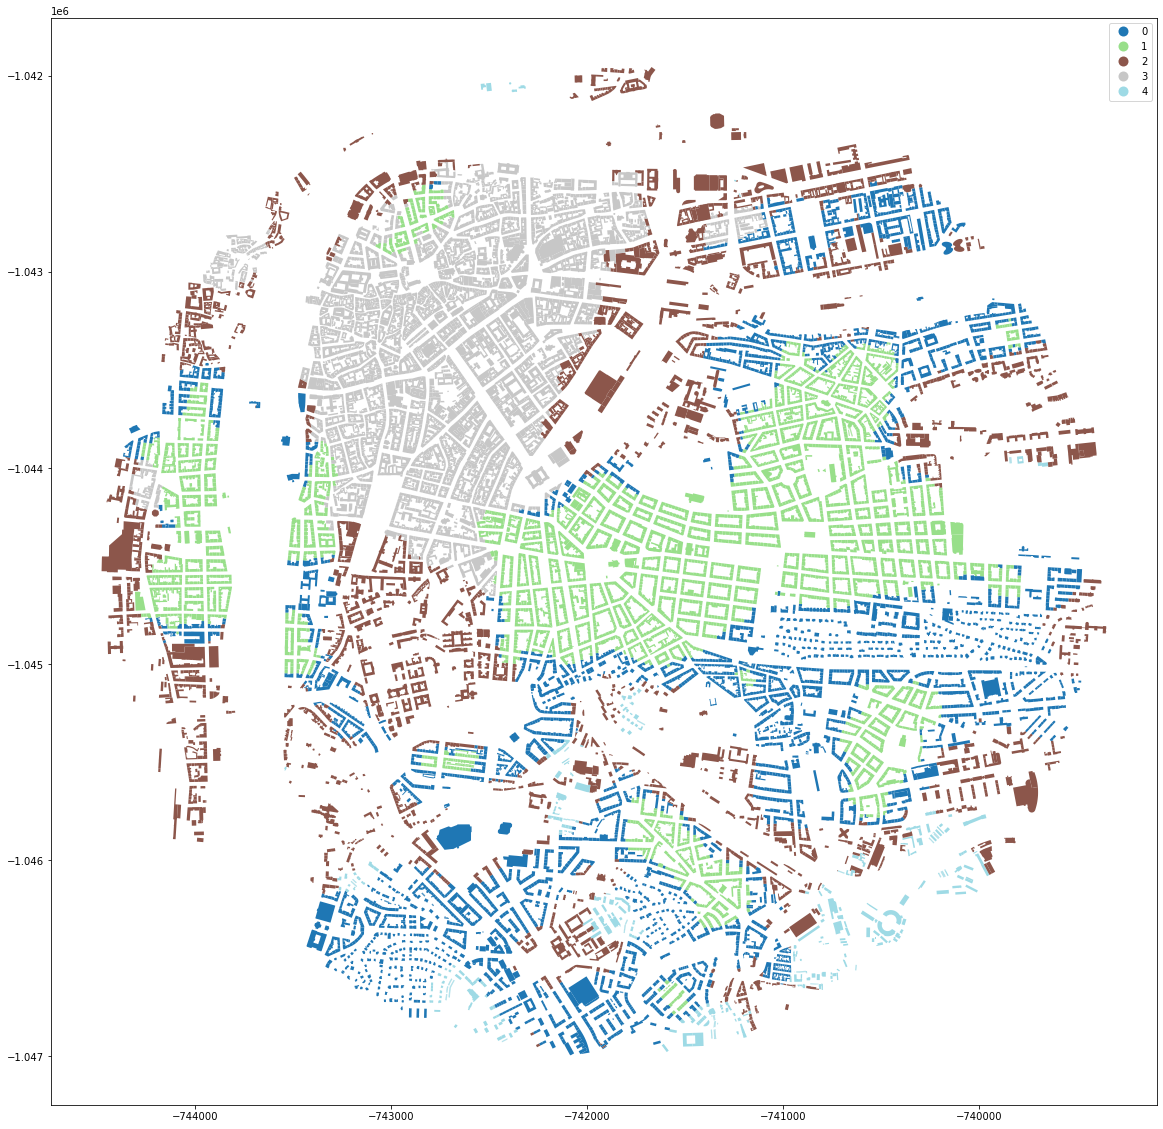

In [ ]:
geom.plot('cluster', categorical=True, cmap='tab20', legend=True, figsize=(20, 20))